# binary activities

In [1]:
import os
import numpy as np 
from astropy.table import Table as aT

In [2]:
from noah2 import data as D
from noah2 import util as U

In [3]:
import torch

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [38]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

# read data
read data set of all CRS participants

In [5]:
DNoah = D.Noah2()
fema = DNoah._read_data_full(participants=True)

In [6]:
metro = ((fema['RUCA1'] == 1))# | (fema['RUCA1'] == 2) | (fema['RUCA1'] == 3)) 
micro = ((fema['RUCA1'] == 4) | (fema['RUCA1'] == 5) | (fema['RUCA1'] == 6))
small = ((fema['RUCA1'] == 7) | (fema['RUCA1'] == 8) | (fema['RUCA1'] == 9))
rural = ((fema['RUCA1'] == 10))

In [29]:
arch_dict = {'metro': metro, 'micro': micro, 'small': small, 'rural': rural}

In [7]:
columns = DNoah._columns()[:8] + ['s_%s' % c for c in ['c350', 'c420', 'c450']]
column_labels = np.array(DNoah._column_labels()[:8] + ['c350', 'c420', 'c450'])

data = np.array([np.array(fema[col]) for col in columns]).T

In [8]:
_data = data.copy()
_data[:,0] = np.log10(_data[:,0])
_data[:,3] = np.log10(_data[:,3])
_data[:,4] = np.log10(_data[:,4])

In [9]:
binary_activities = ['c360', 'c520', 'c530', 'c540', 'c610', 'c620', 'c630']

binary_data = np.array([np.array(fema[col]) for col in binary_activities]).T
binary_data = (binary_data > 0).astype(int)

binary_act_codes = np.zeros(len(fema))
for i in range(binary_data.shape[1]): 
    binary_act_codes += 2**i * binary_data[:,i]

In [10]:
def uncode(num): 
    act = np.zeros(len(binary_activities)).astype(int)
    while num > 0: 
        ind = int(np.floor(np.log(num)/np.log(2)))
        num = num - 2**ind
        act[ind] = 1
    return act

In [11]:
act_enough_stat = []
for code in np.unique(binary_act_codes): 
    ncomm = np.sum(binary_act_codes == code)
    nzip = len(np.unique(fema['zipcode'][binary_act_codes == code]))
    if nzip < 100: continue
    print(uncode(code))        
    print('%i communities' % ncomm)
    print('%i unique zipcodes' % nzip)
    act_enough_stat.append(code)
    print()

[0 0 0 0 0 0 0]
12737 communities
315 unique zipcodes

[0 1 0 0 0 0 0]
3861 communities
118 unique zipcodes

[0 0 0 1 0 0 0]
4399 communities
113 unique zipcodes

[1 0 0 1 0 0 0]
1935 communities
147 unique zipcodes

[0 1 0 1 0 0 0]
52339 communities
119 unique zipcodes

[1 1 0 1 1 0 0]
2798 communities
112 unique zipcodes

[0 0 0 0 0 0 1]
4971 communities
308 unique zipcodes

[0 1 0 0 0 0 1]
2109 communities
234 unique zipcodes

[0 0 0 1 0 0 1]
1005 communities
119 unique zipcodes

[1 1 0 1 0 0 1]
30175 communities
165 unique zipcodes



In [12]:
act_enough_stat

[0.0, 2.0, 8.0, 9.0, 10.0, 27.0, 64.0, 66.0, 72.0, 75.0]

## c360
Lets look for natural experiments that we can use to assess the impact of `c360`. Lets start with rural communities

In [83]:
def find_natural_experiments(act, archetype, verbose=False):
    i_act = binary_activities.index(act)
    arch = {'rural': rural, 'small': small, 'micro': micro, 'metro': metro, 
            'all': np.ones(len(fema)).astype(bool)}[archetype]
    if verbose: print('%s:' % archetype)

    # search for natural experiments 
    experiments = []
    u_act_codes = np.unique(binary_act_codes)
    for i in range(len(u_act_codes)): 
        for j in range(i+1, len(u_act_codes)): 
            if not np.all(uncode(u_act_codes[j]) - uncode(u_act_codes[i]) >= 0): continue
            if np.sum((uncode(u_act_codes[j]) - uncode(u_act_codes[i])) == 1) != 1: continue
            if (uncode(u_act_codes[j]) - uncode(u_act_codes[i]))[i_act] != 1: continue

            is_codei = (binary_act_codes == u_act_codes[i])
            is_codej = (binary_act_codes == u_act_codes[j])


            if np.sum(is_codej & arch) > 0 and np.sum(is_codei & arch) > 0: 
                nzip_i = len(np.unique(fema['zipcode'][is_codei & arch]))
                nzip_j = len(np.unique(fema['zipcode'][is_codej & arch]))
                
                if not u_act_codes[j] in act_enough_stat and not u_act_codes[i] in act_enough_stat: 
                    continue
                
                if np.min([nzip_j, nzip_i]) < 2: continue
                if verbose: 
                    print(uncode(u_act_codes[j]), '-', uncode(u_act_codes[i]))
                    print(u_act_codes[j], '-', u_act_codes[i])
                    print('communities %i - %i' % (np.sum(is_codej & arch), np.sum(is_codei & arch)))
                    print('zipcodes %i - %i' % (nzip_j, nzip_i))
                    print()
                
                # (treated, control) pairs
                experiments.append((u_act_codes[j], u_act_codes[i]))
    return experiments

In [139]:
def load_Qphi_support(binary): 
    ''' load Qphi(X) for binary activity combination
    '''
    Qphi = torch.load('../dat/qphi/noah2.Qphi_support.binary%i.prelim.pt' % int(binary), map_location=device)
    return Qphi

def load_qphi(binary): 
    ''' load qphi(Y|X) for binary activity combination 
    '''
    qphi = torch.load('../dat/qphi/noah2.qphi.binary%i.prelim.pt' % int(binary), map_location=device)
    return qphi

def check_support(binary, X, nsample=10000, threshold=0.95, verbose=False): 
    ''' check support for covariates X
    '''
    X = np.atleast_2d(X).copy()
    # preprocess X
    X[:,0] = U.inv_cdf_transform(X[:,0], [-1e-3, 1500])
    X[:,1] = U.inv_cdf_transform(X[:,1], [-1e-3, 10])
    X[:,2] = U.inv_cdf_transform(X[:,2], [3, 6])        
    X[:,3] = U.inv_cdf_transform(X[:,3], [1, 6])        
    X[:,4] = U.inv_cdf_transform(X[:,4], [-1e-3, 1+1e-3])            
    X[:,5] = U.inv_cdf_transform(X[:,5], [-1e-3, 1+1e-3])            
    X[:,6] = U.inv_cdf_transform(X[:,6], [-1e-3, 1+1e-3])      
    # cdf transfer the CRS activities column    
    X[:,-3] = U.inv_cdf_transform(X[:,-3], [-1e-3, 100.+1e-3])
    X[:,-2] = U.inv_cdf_transform(X[:,-2], [-1e-3, 100.+1e-3])
    X[:,-1] = U.inv_cdf_transform(X[:,-1], [-1e-3, 100.+1e-3])    
    
    # load Qphi 
    Qphi = load_Qphi_support(binary)
    Qphi.to(device)
    
    # check support
    with torch.no_grad(): 
        logpX = np.array(Qphi.log_prob(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu())
        if verbose: print(logpX)
            
        _, logps = Qphi.sample_and_log_prob(nsample)
        logps = np.array(logps.detach().cpu())
    
    support = np.zeros(X.shape[0])
    for i in range(X.shape[0]): 
        support[i] = np.mean(logpX[i] < logps)
    if verbose: print(support)
        
    return (support < threshold)
    
def sample_qphi(binary, X, nsample=10000): 
    ''' sample qphi(Y | X) for some binary combination 
    '''
    # load qphi
    qphi = load_qphi(binary)
    
    # sample
    with torch.no_grad(): 
        samps = []
        for _X in np.atleast_2d(X): 
            samp = qphi.sample((nsample,), 
                               x=torch.tensor(_X, dtype=torch.float32).to(device), 
                               show_progress_bars=False)
            samps.append(np.array(samp.detach().cpu()).flatten())
    return 10**np.array(samps)

def dY_jackknife(dY, zipcodes, func=np.median, njack=5): 
    ''' jackknife uncertainties 
    '''
    mu_dY = func(dY)
    
    mu_dY_jack, n_jack = [], 0
    for i in range(njack): 
        in_jack = ((zipcodes % njack) == i)
        if np.sum(in_jack) == 0: continue
            
        mu_dY_jack.append(func(dY[~in_jack]))
        n_jack += 1
    if n_jack < 3: return np.inf
    
    mu_dY_jack = np.array(mu_dY_jack)
    
    sig_jack = np.sqrt((n_jack - 1)/n_jack * np.sum((mu_dY_jack - mu_dY)**2))
    return sig_jack

In [182]:
def estimate_treatment(activity, archs, nzip_threshold=10, n_jack=10, verbose=False): 
    dY_archs, sig_dY_archs = [], []
    for arch in archs: 
        exps = find_natural_experiments(activity, arch)

        dYs, z_dYs = [], [] 
        for exp in exps: 
            if verbose: print(arch, ':', uncode(exp[0]), '-', uncode(exp[1]))
                
            # find anchor
            treated_code, control_code = exp
            treated_enough, control_enough = False, False
            if treated_code in act_enough_stat: treated_enough = True
            if control_code in act_enough_stat: control_enough = True

            if treated_enough and control_enough: 
                nzip_treated = len(np.unique(np.array(fema['zipcode'])[arch_dict[arch] & (binary_act_codes == treated_code)]))
                nzip_control = len(np.unique(np.array(fema['zipcode'])[arch_dict[arch] & (binary_act_codes == control_code)]))
                if nzip_treated > nzip_control: 
                    treated_enough = True
                    control_enough = False
                if nzip_treated <= nzip_control: 
                    treated_enough = False
                    control_enough = True                

            enough = np.array([treated_enough, control_enough])

            code_samples = np.array(exp)[~enough]
            code_anchor = np.array(exp)[enough]

            X_samples = _data[:,1:][arch_dict[arch] & (binary_act_codes == code_samples)]
            Y_samples = 10**_data[:,0][arch_dict[arch] & (binary_act_codes == code_samples)]
            z_samples = np.array(fema['zipcode'])[arch_dict[arch] & (binary_act_codes == code_samples)]

            # check support for X
            support = check_support(code_anchor, X_samples, nsample=10000, verbose=False)
            if np.sum(support) == 0: continue 
            if verbose: print('%i communities, %i zipcodes' % (np.sum(support), len(np.unique(z_samples[support]))))

            # calculate <Y_anchor> 
            Ys = sample_qphi(code_anchor, X_samples[support], nsample=10000)
            mu_Y_anchor = np.mean(Ys, axis=1)

            dY = (Y_samples[support] - mu_Y_anchor) * (np.array([-1, 1])[enough])[0]
            dYs.append(dY)
            z_dYs.append(z_samples[support])
            
            if verbose: 
                if len(np.unique(z_samples[support])) < nzip_threshold: 
                    continue 
                
                #sig_jack = dY_jackknife(dY, z_samples[support], func=np.median, njack=5)
                #q0, q1, q2 = np.quantile(dY, [0.16, 0.5, 0.84])
                #if verbose: print('  median: %.2f +/-%.2f' % (q1, sig_jack))

                sig_jack = dY_jackknife(dY, z_samples[support], func=np.mean, njack=5)
                q1 = np.mean(dY)
                if verbose: print('  mean: %.2f +/-%.2f' % (q1, sig_jack))

        if len(dYs) == 0: 
            if verbose: print("  Not enough communities\n")
            dY_archs.append(np.inf)
            sig_dY_archs.append(np.inf)
            continue 

        dYs = np.concatenate(dYs)
        z_dYs = np.concatenate(z_dYs)

        if verbose: print('%s : all' % arch)
        if len(np.unique(z_dYs)) < nzip_threshold: 
            if verbose: print("  Not enough communities from different zipcodes; only %i zipcodes\n" % 
                              len(np.unique(z_dYs)))
            dY_archs.append(np.inf)
            sig_dY_archs.append(np.inf)
            continue 
        
        if verbose:     
            print('%i communities, %i zipcodes' % (len(dYs), len(np.unique(z_dYs))))
            for njack in [10, 20, 30]: 
                sig_jack = dY_jackknife(dYs, z_dYs, func=np.median, njack=njack)
                q0, q1, q2 = np.quantile(dYs, [0.16, 0.5, 0.84])
                print('   median: %.2f +/-%.2f' % (q1, sig_jack))

            for njack in [10, 20, 30]:         
                sig_jack = dY_jackknife(dYs, z_dYs, func=np.mean, njack=njack)
                q1 = np.mean(dYs)
                print('   mean: %.2f +/-%.2f' % (q1, sig_jack))
            print()
            print()
            
        sig_jack = dY_jackknife(dYs, z_dYs, func=np.mean, njack=n_jack)
        q1 = np.mean(dYs)   
        
        dY_archs.append(q1)
        sig_dY_archs.append(sig_jack)
        
    return dY_archs, sig_dY_archs

In [174]:
estimate_treatment('c360', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [1 0 0 0 0 0 0] - [0 0 0 0 0 0 0]
2 communities, 1 zipcodes
rural : all
  Not enough communities from different zipcodes; only 1 zipcodes

small : [1 0 0 0 0 0 0] - [0 0 0 0 0 0 0]
1 communities, 1 zipcodes
small : [1 0 0 0 0 0 1] - [0 0 0 0 0 0 1]
70 communities, 3 zipcodes
small : all
  Not enough communities from different zipcodes; only 4 zipcodes

micro : [1 0 0 0 0 0 0] - [0 0 0 0 0 0 0]
26 communities, 6 zipcodes
micro : [1 0 0 1 0 0 0] - [0 0 0 1 0 0 0]
275 communities, 6 zipcodes
micro : [1 0 0 0 0 0 1] - [0 0 0 0 0 0 1]
120 communities, 9 zipcodes
micro : [1 1 0 0 0 0 1] - [0 1 0 0 0 0 1]
69 communities, 5 zipcodes
micro : [1 0 0 1 0 0 1] - [0 0 0 1 0 0 1]
10 communities, 2 zipcodes
micro : [1 1 0 1 0 0 1] - [0 1 0 1 0 0 1]
micro : all
500 communities, 28 zipcodes
   median: -20611.07 +/-3790.36
   median: -20611.07 +/-3637.71
   median: -20611.07 +/-3565.23
   mean: -6425.57 +/-5178.73
   mean: -6425.57 +/-4694.78
   mean: -6425.57 +/-4474.35


metro : [1 0 0 0 0 0 0

([inf, inf, -6425.568440585936, 12381.247342548519],
 [inf, inf, 5178.733657352417, 7791.131356407996])

## c520

In [175]:
estimate_treatment('c520', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [0 1 0 0 0 0 1] - [0 0 0 0 0 0 1]
11 communities, 2 zipcodes
rural : all
  Not enough communities from different zipcodes; only 2 zipcodes

small : [0 1 0 0 0 0 0] - [0 0 0 0 0 0 0]
288 communities, 5 zipcodes
small : [0 1 0 0 0 0 1] - [0 0 0 0 0 0 1]
9 communities, 2 zipcodes
small : all
  Not enough communities from different zipcodes; only 7 zipcodes

micro : [0 1 0 0 0 0 0] - [0 0 0 0 0 0 0]
415 communities, 7 zipcodes
micro : [1 1 0 1 0 0 0] - [1 0 0 1 0 0 0]
12 communities, 4 zipcodes
micro : [0 1 0 0 0 0 1] - [0 0 0 0 0 0 1]
284 communities, 7 zipcodes
micro : [0 1 0 1 0 0 1] - [0 0 0 1 0 0 1]
micro : [1 1 0 1 0 0 1] - [1 0 0 1 0 0 1]
micro : all
711 communities, 18 zipcodes
   median: -5183.27 +/-13423.50
   median: -5183.27 +/-13615.91
   median: -5183.27 +/-13856.56
   mean: 22384.22 +/-20023.59
   mean: 22384.22 +/-20178.96
   mean: 22384.22 +/-20561.55


metro : [0 1 0 0 0 0 0] - [0 0 0 0 0 0 0]
949 communities, 66 zipcodes
  mean: -1106.88 +/-10442.88

metro : [0 1

([inf, inf, 22384.224849859358, -2819.877564766716],
 [inf, inf, 20023.593916884052, 3120.4617144988547])

## c530

In [179]:
estimate_treatment('c530', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [0 0 1 0 0 0 0] - [0 0 0 0 0 0 0]
3 communities, 2 zipcodes
rural : all
  Not enough communities from different zipcodes; only 2 zipcodes

micro : [0 0 1 0 0 0 0] - [0 0 0 0 0 0 0]
3 communities, 3 zipcodes
micro : [0 1 1 0 0 0 0] - [0 1 0 0 0 0 0]
160 communities, 2 zipcodes
micro : [0 1 1 0 0 0 1] - [0 1 0 0 0 0 1]
12 communities, 1 zipcodes
micro : all
  Not enough communities from different zipcodes; only 6 zipcodes

metro : [0 0 1 0 0 0 0] - [0 0 0 0 0 0 0]
338 communities, 8 zipcodes
metro : [0 1 1 0 0 0 0] - [0 1 0 0 0 0 0]
5 communities, 2 zipcodes
metro : [1 0 1 1 0 0 0] - [1 0 0 1 0 0 0]
94 communities, 10 zipcodes
  mean: -6257.14 +/-3355.32

metro : [0 1 1 1 0 0 0] - [0 1 0 1 0 0 0]
metro : [1 1 1 1 1 0 0] - [1 1 0 1 1 0 0]
324 communities, 3 zipcodes
metro : [0 1 1 0 0 0 1] - [0 1 0 0 0 0 1]
112 communities, 10 zipcodes
  mean: 45701.71 +/-51814.65

metro : [1 1 1 1 0 0 1] - [1 1 0 1 0 0 1]
132 communities, 6 zipcodes
metro : all
1005 communities, 39 zipcodes
   me

([inf, inf, inf, 18563.030629639823], [inf, inf, inf, 7992.6452768869785])

## c540

In [181]:
estimate_treatment('c540', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [1 0 0 1 0 0 0] - [1 0 0 0 0 0 0]
small : [0 0 0 1 0 0 0] - [0 0 0 0 0 0 0]
442 communities, 4 zipcodes
small : all
  Not enough communities from different zipcodes; only 4 zipcodes

micro : [0 0 0 1 0 0 0] - [0 0 0 0 0 0 0]
317 communities, 6 zipcodes
micro : [1 0 0 1 0 0 0] - [1 0 0 0 0 0 0]
28 communities, 6 zipcodes
micro : [0 0 0 1 0 0 1] - [0 0 0 0 0 0 1]
5 communities, 3 zipcodes
micro : [0 1 0 1 0 0 1] - [0 1 0 0 0 0 1]
6 communities, 2 zipcodes
micro : [1 1 0 1 0 0 1] - [1 1 0 0 0 0 1]
micro : all
356 communities, 17 zipcodes
   median: -9410.72 +/-18928.31
   median: -9410.72 +/-13821.66
   median: -9410.72 +/-11303.95
   mean: -1540.07 +/-2247.84
   mean: -1540.07 +/-1148.95
   mean: -1540.07 +/-4563.05


metro : [0 0 0 1 0 0 0] - [0 0 0 0 0 0 0]
1394 communities, 65 zipcodes
  mean: 1353.24 +/-9754.19
metro : [1 0 0 1 0 0 0] - [1 0 0 0 0 0 0]
217 communities, 25 zipcodes
  mean: 1311.85 +/-8254.71
metro : [0 1 0 1 0 0 0] - [0 1 0 0 0 0 0]
metro : [1 1 0 1 1 0 0] - [

([inf, inf, -1540.0731570159403, 10246.676244871562],
 [inf, inf, 2247.835210772511, 5787.054655626049])

## c610

In [183]:
estimate_treatment('c610', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [0 0 0 0 1 0 0] - [0 0 0 0 0 0 0]
24 communities, 2 zipcodes
rural : all
  Not enough communities from different zipcodes; only 2 zipcodes

small : [0 0 0 0 1 0 0] - [0 0 0 0 0 0 0]
174 communities, 2 zipcodes
small : all
  Not enough communities from different zipcodes; only 2 zipcodes

micro : [0 0 0 0 1 0 0] - [0 0 0 0 0 0 0]
3364 communities, 14 zipcodes
  mean: -874.40 +/-3062.36
micro : [0 0 0 0 1 0 1] - [0 0 0 0 0 0 1]
115 communities, 2 zipcodes
micro : all
3479 communities, 15 zipcodes
   median: -10954.47 +/-1453.95
   median: -10954.47 +/-1288.37
   median: -10954.47 +/-1368.21
   mean: -483.99 +/-3100.18
   mean: -483.99 +/-2563.25
   mean: -483.99 +/-3166.75


metro : [0 0 0 0 1 0 0] - [0 0 0 0 0 0 0]
262 communities, 7 zipcodes
metro : [0 1 0 0 1 0 0] - [0 1 0 0 0 0 0]
1734 communities, 29 zipcodes
  mean: 32883.71 +/-13727.61
metro : [0 0 0 1 1 0 0] - [0 0 0 1 0 0 0]
1919 communities, 54 zipcodes
  mean: 9632.53 +/-8255.00
metro : [1 0 0 1 1 0 0] - [1 0 0 1 0 0 0

([inf, inf, -483.98550820170243, 16196.323788170916],
 [inf, inf, 3100.1821669844994, 6775.803559937712])

## c620

In [184]:
estimate_treatment('c620', ['rural', 'small', 'micro', 'metro'], verbose=True)

  Not enough communities

  Not enough communities

  Not enough communities

metro : [1 1 0 1 0 1 1] - [1 1 0 1 0 0 1]
  Not enough communities



([inf, inf, inf, inf], [inf, inf, inf, inf])

## c630

In [185]:
estimate_treatment('c630', ['rural', 'small', 'micro', 'metro'], verbose=True)

rural : [0 0 0 0 0 0 1] - [0 0 0 0 0 0 0]
35 communities, 9 zipcodes
rural : all
  Not enough communities from different zipcodes; only 9 zipcodes

small : [0 0 0 0 0 0 1] - [0 0 0 0 0 0 0]
35 communities, 6 zipcodes
small : [0 1 0 0 0 0 1] - [0 1 0 0 0 0 0]
5 communities, 2 zipcodes
small : all
  Not enough communities from different zipcodes; only 7 zipcodes

micro : [0 0 0 0 0 0 1] - [0 0 0 0 0 0 0]
403 communities, 20 zipcodes
  mean: 10895.41 +/-13186.79
micro : [0 1 0 0 0 0 1] - [0 1 0 0 0 0 0]
282 communities, 6 zipcodes
micro : [0 0 0 1 0 0 1] - [0 0 0 1 0 0 0]
5 communities, 3 zipcodes
micro : [1 0 0 1 0 0 1] - [1 0 0 1 0 0 0]
10 communities, 2 zipcodes
micro : [1 1 0 1 0 0 1] - [1 1 0 1 0 0 0]
2 communities, 2 zipcodes
micro : all
702 communities, 31 zipcodes
   median: -3290.63 +/-6374.97
   median: -3290.63 +/-6489.85
   median: -3290.63 +/-6419.48
   mean: 16372.87 +/-7464.14
   mean: 16372.87 +/-7037.69
   mean: 16372.87 +/-7312.01


metro : [0 0 0 0 0 0 1] - [0 0 0 0 0 0

([inf, inf, 16372.872905843793, 10682.915197390044],
 [inf, inf, 7464.140531130008, 6998.704203708321])

In [186]:
dYs, sig_dYs = [], []
for activity in binary_activities: 
    dY, sig_dY = estimate_treatment(activity, ['rural', 'small', 'micro', 'metro'], verbose=False)

    dYs.append(np.array(dY))
    sig_dYs.append(np.array(sig_dY))
    
dYs = np.array(dYs).T
sig_dYs = np.array(sig_dYs).T

In [213]:
np.save('dYs.binary.npy', dYs)
np.save('sig_dYs.binary.npy', sig_dYs)

Text(0, 0.5, 'impact of CRS activities [10,000 USD/policy]')

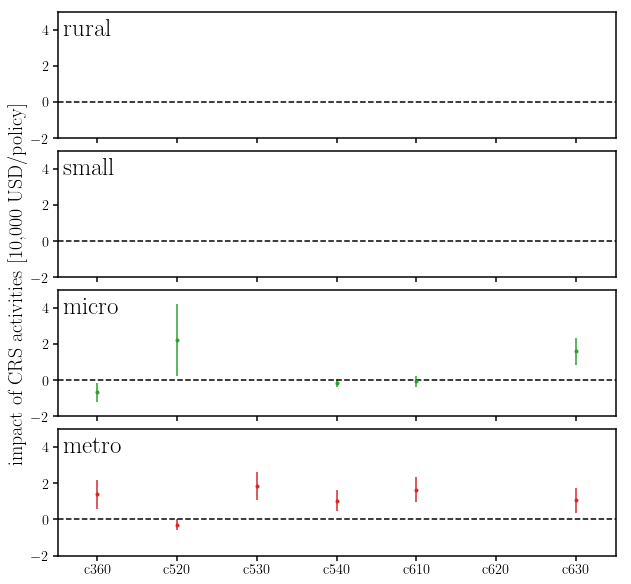

In [211]:
fig = plt.figure(figsize=(10,10))

for i_arch, arch in enumerate(['rural', 'small', 'micro', 'metro']): 
    sub = fig.add_subplot(4,1,i_arch+1)
    
    enough_stat = np.isfinite(dYs[i_arch])
    #print(np.arange(len(binary_activities))[enough_stat])
    sub.errorbar(np.arange(len(binary_activities))[enough_stat], dYs[i_arch][enough_stat]/1e4, 
                 yerr=[sig_dYs[i_arch][enough_stat]/1e4, sig_dYs[i_arch][enough_stat]/1e4], 
                 fmt='.C%i' % i_arch)
    #sub.scatter(np.arange(len(binary_activities))[np.isfinite(dYs[i_arch])], 
    #            dYs[i_arch][np.isfinite(dYs[i_arch])]/1e4, color='C%i' % i_arch, s=20)    
    
   
    sub.text(0.01, 0.95, arch, transform=sub.transAxes, ha='left', va='top', fontsize=25)
    sub.axhline(0., color='k', linestyle='--')    
    sub.set_xlim(-0.5, 6.5)
    sub.set_xticks(np.arange(7))
    sub.set_xticklabels([])
    sub.set_ylim(-2., 5.)
    
sub.set_xticklabels(binary_activities)
fig.subplots_adjust(hspace=0.1)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("impact of CRS activities [10,000 USD/policy]", fontsize=20)